# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [49]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

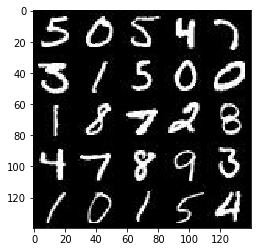

In [50]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

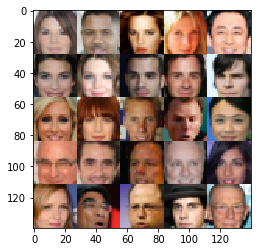

In [51]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [53]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None , image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [54]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True) 
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #Flatten 
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=0.75)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [68]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #drop = 0.5
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        #drop1 = tf.nn.dropout(relu1, drop)
        
        #256
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #drop2 = tf.nn.dropout(relu2, drop)
        
        #128
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #drop3 = tf.nn.dropout(relu3, drop)
        
        #Output
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              padding='same') 
        logits = tf.layers.dropout(logits, rate=0.5)
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [63]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    #Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample, if it is real, then replace the label with a random number between 0.7 and 1.2, and if it is a fake sample, replace it with 0.0 and 0.3 (for example).
    #Salimans et. al. 2016
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [64]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [65]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [66]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                #Normalize
                batch_images *= 2
                #Sample Noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #Optimizer 
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, learn_rate: learning_rate})
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6919... Generator Loss: 0.3021
Epoch 1/2... Discriminator Loss: -1.2026... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: -2.4224... Generator Loss: 5.1761
Epoch 1/2... Discriminator Loss: 2.9736... Generator Loss: 0.1869
Epoch 1/2... Discriminator Loss: -0.3596... Generator Loss: 6.9472
Epoch 1/2... Discriminator Loss: 1.6358... Generator Loss: 0.6963
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 2.0254
Epoch 1/2... Discriminator Loss: 0.8256... Generator Loss: 1.7898
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 1.2261
Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 1.5517


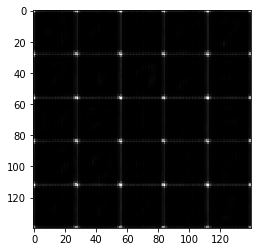

Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 1.9710
Epoch 1/2... Discriminator Loss: 1.3460... Generator Loss: 1.0529
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 1.2206
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 0.6312
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 1.0909... Generator Loss: 0.4977
Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 0.8500


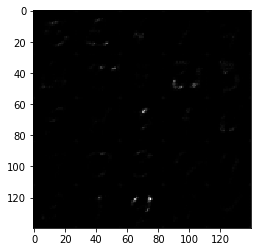

Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 1.2267
Epoch 1/2... Discriminator Loss: 0.9338... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 0.8794... Generator Loss: 1.3042
Epoch 1/2... Discriminator Loss: 0.7271... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 0.7726... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 0.4050
Epoch 1/2... Discriminator Loss: 0.7423... Generator Loss: 1.1423
Epoch 1/2... Discriminator Loss: 0.6719... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 1.0832... Generator Loss: 0.3122
Epoch 1/2... Discriminator Loss: 0.7983... Generator Loss: 0.6123


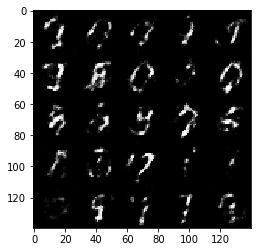

Epoch 1/2... Discriminator Loss: 0.9030... Generator Loss: 0.4029
Epoch 1/2... Discriminator Loss: 0.4482... Generator Loss: 1.1877
Epoch 1/2... Discriminator Loss: 1.0165... Generator Loss: 0.3329
Epoch 1/2... Discriminator Loss: 0.8490... Generator Loss: 0.4567
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.4613
Epoch 1/2... Discriminator Loss: 0.8982... Generator Loss: 0.4274
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 0.6236
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 1.1944
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 1.3116
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.2093


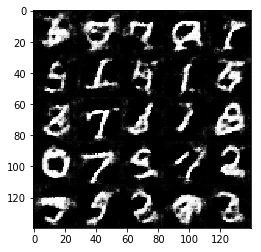

Epoch 1/2... Discriminator Loss: 0.7869... Generator Loss: 0.5522
Epoch 1/2... Discriminator Loss: 0.8279... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 1.5451
Epoch 1/2... Discriminator Loss: 1.2856... Generator Loss: 0.2570
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 0.4243
Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 0.6111
Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 0.5486
Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 0.5019
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 0.7620
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 1.1916


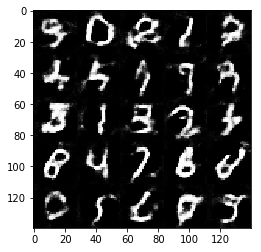

Epoch 2/2... Discriminator Loss: 0.8367... Generator Loss: 0.5228
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 0.4166
Epoch 2/2... Discriminator Loss: 0.7506... Generator Loss: 2.0797
Epoch 2/2... Discriminator Loss: 0.8329... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 0.4033
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 1.4425
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 0.8915... Generator Loss: 1.1298
Epoch 2/2... Discriminator Loss: 0.7855... Generator Loss: 1.6217
Epoch 2/2... Discriminator Loss: 1.0643... Generator Loss: 0.3498


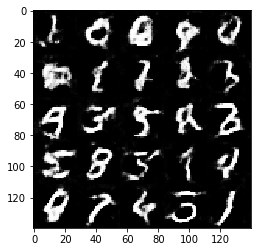

Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.3162
Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 0.6744
Epoch 2/2... Discriminator Loss: 0.9657... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.3618
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.3652
Epoch 2/2... Discriminator Loss: 0.8637... Generator Loss: 0.8907
Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 0.6207
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 0.4773
Epoch 2/2... Discriminator Loss: 0.7809... Generator Loss: 1.1759


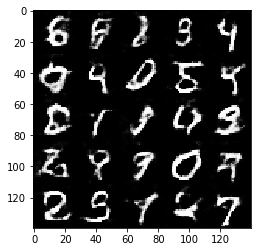

Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.0045
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 0.7057
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 0.4132
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 0.9025... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.1370
Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 0.8186
Epoch 2/2... Discriminator Loss: 0.8042... Generator Loss: 0.6699
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 1.5987
Epoch 2/2... Discriminator Loss: 0.8312... Generator Loss: 0.5796


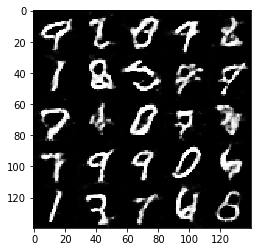

Epoch 2/2... Discriminator Loss: 1.1878... Generator Loss: 0.2649
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.6982
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 1.1628
Epoch 2/2... Discriminator Loss: 0.5743... Generator Loss: 0.7478
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 0.4758
Epoch 2/2... Discriminator Loss: 0.7396... Generator Loss: 0.7784
Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 1.2244
Epoch 2/2... Discriminator Loss: 0.5679... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 0.8785... Generator Loss: 0.6136
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 0.7750


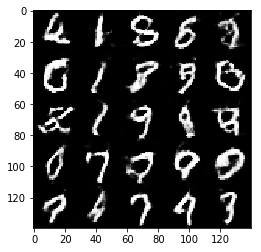

Epoch 2/2... Discriminator Loss: 1.2935... Generator Loss: 3.1142
Epoch 2/2... Discriminator Loss: 0.3575... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 0.5874... Generator Loss: 0.8265


In [69]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 2.9329
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 2.9998
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 1.9369
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 2.2808
Epoch 1/1... Discriminator Loss: 2.4575... Generator Loss: 7.1017
Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 3.1751
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.0173
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 3.6339


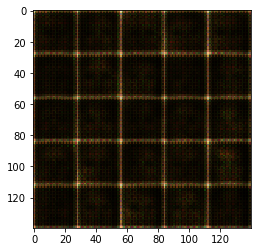

Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 2.7223
Epoch 1/1... Discriminator Loss: 0.5893... Generator Loss: 2.6915
Epoch 1/1... Discriminator Loss: 0.5960... Generator Loss: 2.2246
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 2.6925
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.6087
Epoch 1/1... Discriminator Loss: 1.6004... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 0.8182... Generator Loss: 5.7362
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 2.3705
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 6.7654
Epoch 1/1... Discriminator Loss: 0.5002... Generator Loss: 2.9024


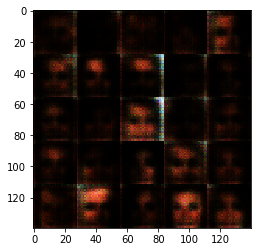

Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 3.1729
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.5837
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 2.0329
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.8210
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.6488
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.6068... Generator Loss: 0.4273


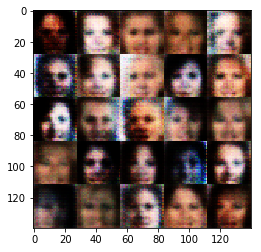

Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 3.9194
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 3.5367
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 1.6734... Generator Loss: 3.8508
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 2.5848
Epoch 1/1... Discriminator Loss: 1.8798... Generator Loss: 3.1297
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 1.8250
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 2.8087
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 3.3730


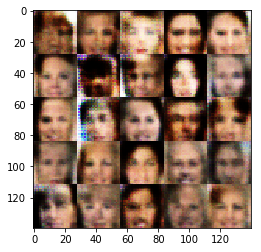

Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.8089
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 2.7086
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.8922
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 2.1138
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.5845


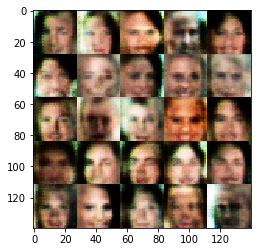

Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.4576
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 2.5595
Epoch 1/1... Discriminator Loss: 2.4149... Generator Loss: 0.1694
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.6065
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.1286


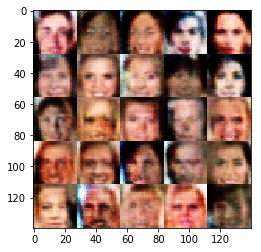

Epoch 1/1... Discriminator Loss: 1.7740... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 2.4627
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.5820
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.2908
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.4633
Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 2.4129
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 2.4708
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 2.0718... Generator Loss: 3.1232


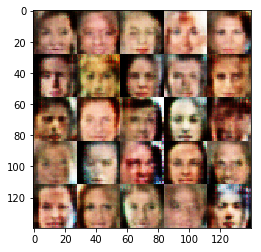

Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 0.6377... Generator Loss: 3.0601
Epoch 1/1... Discriminator Loss: 2.3498... Generator Loss: 0.1881
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 2.8122
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 1.9789
Epoch 1/1... Discriminator Loss: 0.6166... Generator Loss: 2.0695
Epoch 1/1... Discriminator Loss: 0.9246... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 2.0296


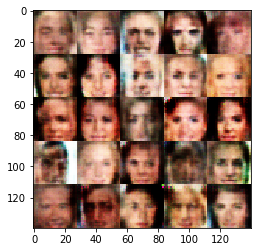

Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 3.6293
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 1.5807
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.1885


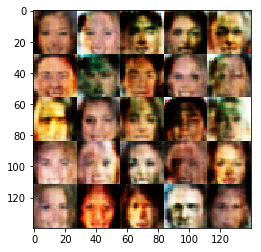

Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 2.7305
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 1.6072
Epoch 1/1... Discriminator Loss: 1.7244... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 1.5865
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.7992
Epoch 1/1... Discriminator Loss: 1.6490... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.1895


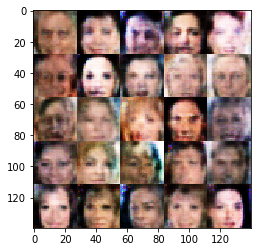

Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.4456
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 1.0622
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 1.6174


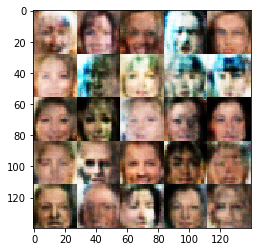

Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.6182
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 3.5333
Epoch 1/1... Discriminator Loss: 1.7448... Generator Loss: 0.4274
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.4203
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.1013


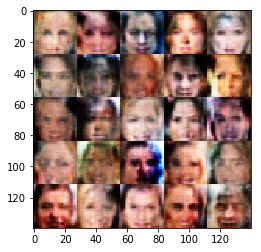

Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 2.6724
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 5.0224
Epoch 1/1... Discriminator Loss: 1.6960... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 1.9052
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 0.9812


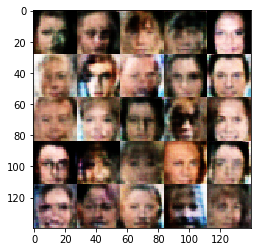

Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 1.2404
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 4.6117
Epoch 1/1... Discriminator Loss: 1.6721... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 2.2195
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 2.0417
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 2.0466


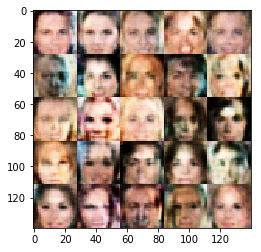

Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 2.4159
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.6002
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.3700


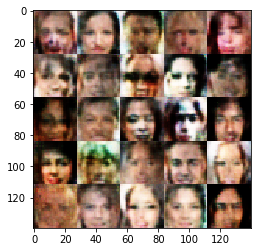

Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 2.1979
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 2.0156
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 1.1948


In [71]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.